Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.2) 비트코인 시세 예측하기

### 바로가기

- [<Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기](#<Step1.-탐색>-:-시간정보가-포함된-데이터-살펴보기)
    - [market price 데이터셋의 기본 정보]
    - [시계열 데이터 살펴보기]
- [<Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측](#<Step2.-예측>-:-파이썬-라이브러리를-활용한-시세-예측)
    - [ARIMA 모델 활용하기]
    - [Facebook Prophet 활용하기]
- [<Step3. 활용> : 더 나은 결과를 위한 방법들](#<Step3.-활용>-:-더-나은-결과를-위한-방법들)
    - [상한가 및 하한가 선정]
    - [이상치 제거하기]
    - [하이퍼 파라미터 선정하기]
- [재미로 알아보는 내일의 비트코인 시세](#재미로-알아보는-내일의-비트코인-시세)

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [10]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [7]:
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [8]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


-----

### [시계열 데이터 살펴보기]

In [11]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
print(bitcoin_df.head())
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
print(bitcoin_df.head())
# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
print(bitcoin_df.head())
bitcoin_df.set_index('day', inplace=True)
print(bitcoin_df.head())

                   day        price
0  2017-08-27 00:00:00  4354.308333
1  2017-08-28 00:00:00  4391.673517
2  2017-08-29 00:00:00  4607.985450
3  2017-08-30 00:00:00  4594.987850
4  2017-08-31 00:00:00  4748.255000
         day        price
0 2017-08-27  4354.308333
1 2017-08-28  4391.673517
2 2017-08-29  4607.985450
3 2017-08-30  4594.987850
4 2017-08-31  4748.255000
                  day        price
day                               
2017-08-27 2017-08-27  4354.308333
2017-08-28 2017-08-28  4391.673517
2017-08-29 2017-08-29  4607.985450
2017-08-30 2017-08-30  4594.987850
2017-08-31 2017-08-31  4748.255000
                  price
day                    
2017-08-27  4354.308333
2017-08-28  4391.673517
2017-08-29  4607.985450
2017-08-30  4594.987850
2017-08-31  4748.255000


In [6]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


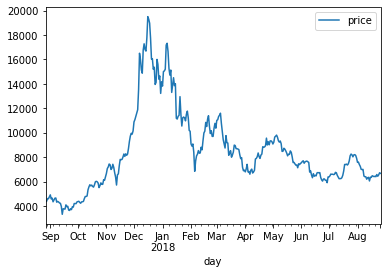

In [5]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

-----

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

###### ARIMA 모델 학습

In [18]:
!pip install(statsmodels)

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

zsh:1: number expected
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Mon, 28 Dec 2020   AIC                           5587.107
Time:                        22:02:46   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3599     27.794      0.229      0.819     -48.116      60.835
ar.L1.D.y     -0.3787      1.826     -0.207      0.836      -3.957       3.200
ar.L2.D.y      0.1586      1.

-----

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

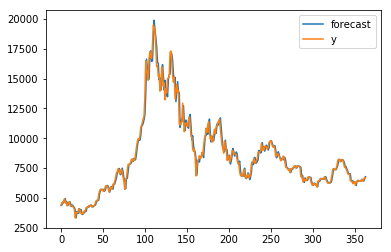

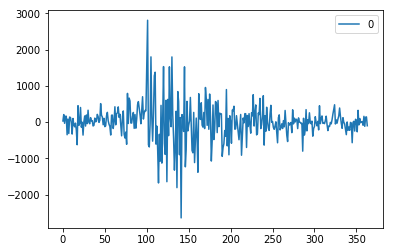

In [9]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [32]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

[6676.92339173 6685.06217981 6690.318354   6697.37838136 6703.29800434]
[ 512.41529718  753.50464333  914.97849982 1061.45414561 1184.43967216]
[[5672.60786413 7681.23891933]
 [5208.22021669 8161.90414293]
 [4896.99344771 8483.64326028]
 [4616.96648472 8777.790278  ]
 [4381.83890505 9024.75710363]]


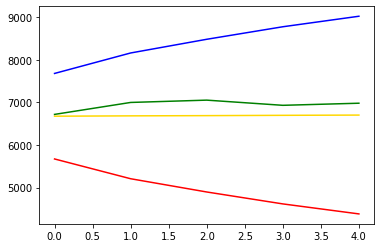

In [33]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

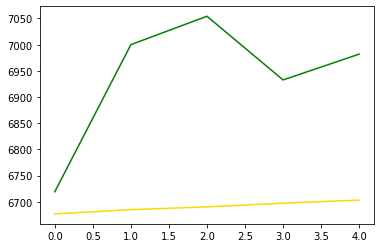

In [34]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

- test RMSE 점수 : 309.05

In [36]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))

#rmse란?
#표준편차와 동일하다. 특정 수치에 대한 예측의 정확도를 표현할 때, 
#Accuracy로 판단하기에는 정확도를 올바르게 표기할 수 없어, 
#RMSE 수치로 정확도 판단을 하곤 한다. 일반적으로 해당 수치가 낮을수록 정확도가 높다고 판단한다.

print(rmse) #rmse점수가 낮을수록 정확도가 높다.

270.72968971712174


-----

### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측합니다. 수치가 높을수록 overfitting에 가까워집니다.

###### Prophet 모델 학습

In [38]:
from fbprophet import Prophet

In [39]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

-----

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [40]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [41]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,761.241924,6283.799891,7620.842046,761.241924,761.241924,10.100264,10.100264,10.100264,8.154825,...,-0.005909,-0.005909,-0.005909,-1.939531,-1.939531,-1.939531,0.0,0.0,0.0,6969.036230
366,2018-08-28,765.967240,6371.213134,7732.690635,765.967240,765.967240,10.100264,10.100264,10.100264,8.232041,...,0.015470,0.015470,0.015470,-1.883693,-1.883693,-1.883693,0.0,0.0,0.0,7071.441338
367,2018-08-29,770.692555,6477.926085,7793.214290,770.692555,770.692555,10.100264,10.100264,10.100264,8.212348,...,-0.044655,-0.044655,-0.044655,-1.843261,-1.843261,-1.843261,0.0,0.0,0.0,7099.888013
368,2018-08-30,775.417870,6399.869318,7919.635211,765.923288,779.262912,10.100264,10.100264,10.100264,8.264572,...,-0.014132,-0.014132,-0.014132,-1.821560,-1.821560,-1.821560,0.0,0.0,0.0,7183.914940
369,2018-08-31,780.143186,6516.875983,8021.333934,760.838928,794.799620,10.100264,10.100264,10.100264,8.315117,...,0.036222,0.036222,0.036222,-1.821369,-1.821369,-1.821369,0.0,0.0,0.0,7267.124950


In [42]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6969.036230,6283.799891,7620.842046
366,2018-08-28,7071.441338,6371.213134,7732.690635
367,2018-08-29,7099.888013,6477.926085,7793.214290
368,2018-08-30,7183.914940,6399.869318,7919.635211
369,2018-08-31,7267.124950,6516.875983,8021.333934


-----

###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

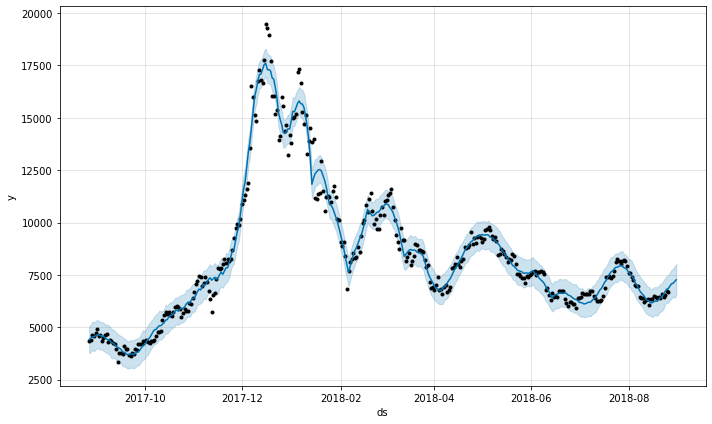

In [43]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

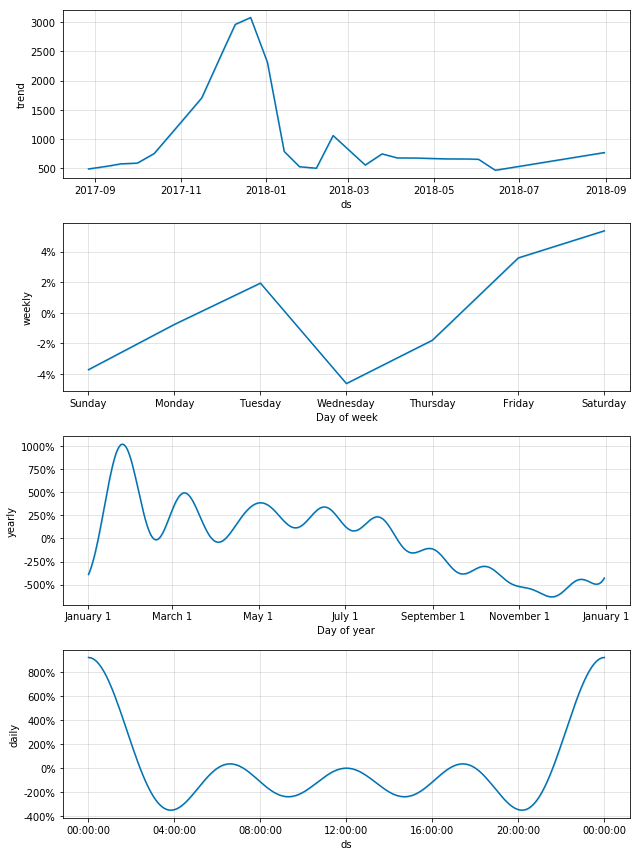

In [20]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.
- train RMSE 점수 : 521.5
- train r2 점수 (train 데이터에 대한 모델의 설명력) : 0.97

In [21]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [22]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

521.4617527207555
0.97386175731469


-----

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [23]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

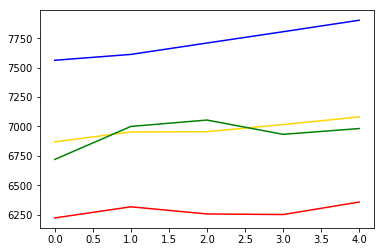

In [24]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

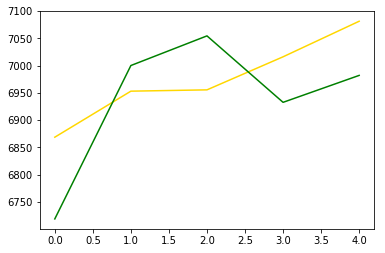

In [25]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

- test RMSE 점수 : 101.1

In [26]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

101.10270853692928


-----

# <Step3. 활용> : 더 나은 결과를 위한 방법들

### [상한가 및 하한가 선정]

- 주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 합니다.

In [27]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [28]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

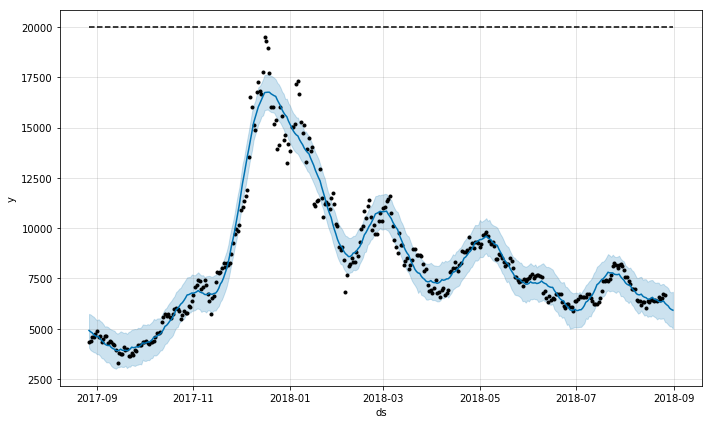

In [29]:
fig = prophet.plot(forecast_data)

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

In [30]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

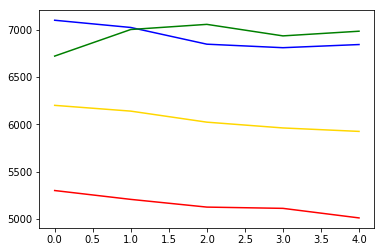

In [31]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

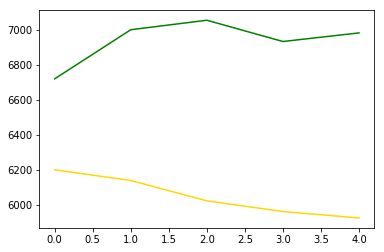

In [32]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

- test RMSE 점수 : 910.36

In [33]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

910.3614860966733


-----

### [이상치 제거하기]

- 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거합니다.

In [34]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

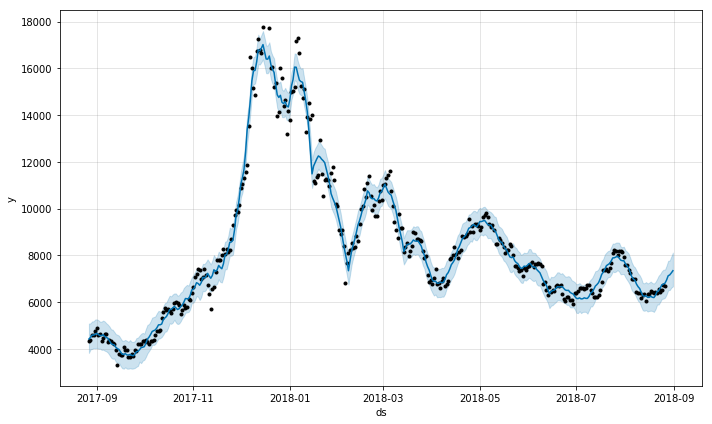

In [35]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

In [36]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

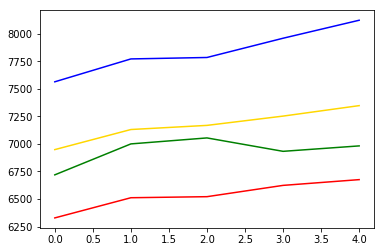

In [37]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

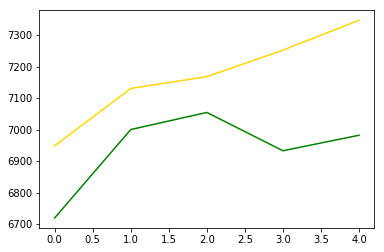

In [38]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

- test RMSE 점수 : 252.18

In [39]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

252.17892671748956


-----

### `한걸음 더 나아가기`

### [ARIMA 모델의 하이퍼 파라미터 선정하기]

###### 적절한 파라미터 선정하기
- ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요합니다.
- ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정합니다.

In [40]:
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

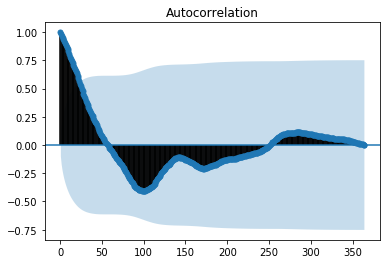

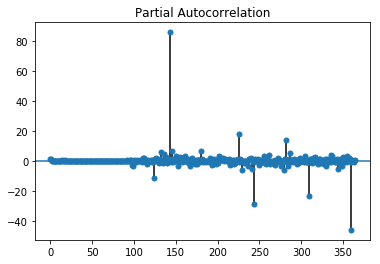

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

-----

###### ARIMA 모델 학습
- 그래프를 토대로 1차 학습

In [42]:
model = ARIMA(bitcoin_df.price.values, order=(15,2,0))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  363
Model:                ARIMA(15, 2, 0)   Log Likelihood               -2766.312
Method:                       css-mle   S.D. of innovations            491.703
Date:                Sat, 09 Feb 2019   AIC                           5566.625
Time:                        18:33:29   BIC                           5632.830
Sample:                             2   HQIC                          5592.941
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0053      4.347     -0.001      0.999      -8.525       8.514
ar.L1.D2.y     -0.8160      0.052    -15.652      0.000      -0.918      -0.714
ar.L2.D2.y     -0.7860      0.068    -11.633    

-----

- 1차 결과를 토대로 2차 학습

In [43]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Sat, 09 Feb 2019   AIC                           5572.148
Time:                        18:33:36   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3936     26.944      0.237      0.813     -46.416      59.203
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

-----

# 재미로 알아보는 내일의 비트코인 시세

###### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 봅시다.

In [44]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [45]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [46]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

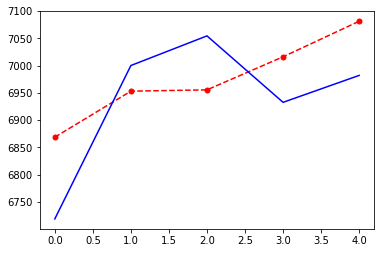

In [47]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.